In [1]:
import snap
from operator import itemgetter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from random import choice
from pandas import datetools
import datetime
import numpy as np
from __future__ import division

### Takes as input an edge list and a metadata filtered upon the nodes in the edgelist

In [2]:
ego = 4

In [3]:
edges_filtered = pd.read_csv('data/Ego '+str(ego)+'/ego_edges'+str(ego)+'.csv',',', index_col=None, comment='#')
ego_nodes = pd.read_csv('data/Ego '+str(ego)+'/ego_nodes'+str(ego)+'.csv',',', index_col=None, comment='#')
metadata_filtered = pd.read_csv('data/Ego '+str(ego)+'/ego_meta'+str(ego)+'.csv', ',')
metadata_filtered['Timestamp']=metadata_filtered['Timestamp'].astype('datetime64')
metadata_filtered=metadata_filtered.sort_values(by=['Timestamp'])

In [4]:
metadata_filtered['Time_Window']=metadata_filtered['Timestamp'].dt.year*100+metadata_filtered['Timestamp'].dt.week

### Count distinct users and time-window per category

In [5]:
emotions = pd.DataFrame(metadata_filtered.groupby('emotion_name').Time_Window.nunique())
emotions['Users'] = pd.DataFrame(metadata_filtered.groupby('emotion_name').id.nunique())

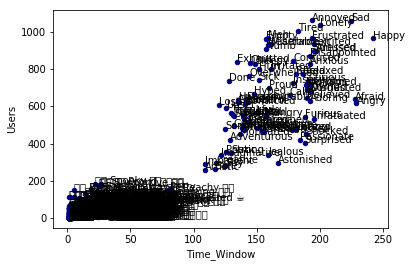

In [6]:
ax = emotions.plot.scatter(x='Time_Window',
...                       y='Users',
...                       c='DarkBlue')


for i, txt in enumerate(emotions.index):
    ax.annotate(txt.decode('utf-8'), (emotions.Time_Window.iat[i],emotions.Users.iat[i]))
    
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [7]:
emotion_categories = metadata_filtered[metadata_filtered['emotion_name'].isin(['Happy', 'Frustrated', 'Lonely', 'Sad',
                                                                               'Annoyed', 'Afraid', 'Angry'])]
emotion_categories = emotion_categories.groupby('emotion_name')['emotion_name'].count()
emotion_categories = pd.DataFrame(emotion_categories)
emotion_categories = emotion_categories.rename(columns={'emotion_name':'Count'})

In [8]:
emotion_categories = emotion_categories.sort_values('Count',ascending=False)

In [9]:
top_emotions = emotion_categories/sum(emotion_categories['Count'])
top_emotions

,Count
emotion_name,
Sad,0.240323
Annoyed,0.214214
Lonely,0.171641
Happy,0.143447
Frustrated,0.122660
Angry,0.055041
Afraid,0.052674


### Computes the average coincidences in emotions category within backward time window of n_days

In [25]:
def emotion_spread(n_sims, category_name):
    
    ratio=[np.array([None]*6)]
    
    for i in np.arange(0,n_sims,1):
        
        vent = metadata_filtered[metadata_filtered['emotion_name']==category_name].sample(1)
        
        ratio0 = []
        
        for n_days in np.arange(2, 8.0, 1):
            
            mean_ratio0=0
            ratio1=0
            node = vent.id
            emotion = vent.emotion_id
            category = vent.emotion_category_id
            time = vent.Timestamp

            #node_neighbors_in = edges_filtered[edges_filtered[['Target']].values==node.values][['Source']]

            #metadata_neighbors = pd.merge(metadata_filtered, node_neighbors_in[['Source']], left_on='id',right_on='Source',how='inner')

            #metadata_neighbors=metadata_neighbors[(metadata_neighbors['Timestamp'].values<time.values-pd.Timedelta(days=n_days-2)) &
                                     #(metadata_neighbors['Timestamp'].values>=time.values-pd.Timedelta(days=n_days))]

            #-pd.Timedelta(days=n_days-2)
            
            metadata_neighbors=metadata_filtered[(metadata_filtered['Timestamp'].values<time.values-pd.Timedelta(days=n_days-2)) &
                                     (metadata_filtered['Timestamp'].values>=time.values-pd.Timedelta(days=n_days))]

            emotions_negihbors = metadata_neighbors.groupby('emotion_id')['Timestamp'].agg(['count'])
            
            if emotions_negihbors[emotions_negihbors.index.values==emotion.values]['count'].values.size > 0:
            
                ratio1 = emotions_negihbors[emotions_negihbors.index.values==emotion.values]['count'].values/sum(emotions_negihbors['count'].values)
            
            else:
                
                ratio1 = np.array(0)
                
            ratio0 = np.append(ratio0, ratio1)

        ratio = np.append(ratio, [ratio0],axis=0)
        
    ratio=np.mat(ratio[1:-1])
    
    ratio=ratio.mean(0)
    return ratio
        

In [26]:
ratios = {}
n_sims=5000
for category_name in top_emotions.index.values:
    ratios[category_name]=emotion_spread(n_sims, category_name)

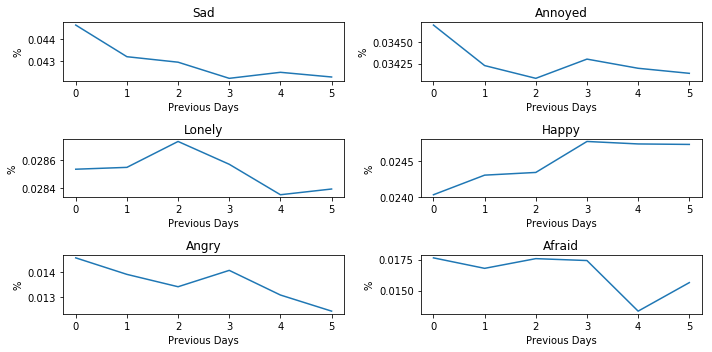

In [50]:
plt.subplot(3, 2, 1)
plt.plot(ratios['Sad'].T)
plt.title('Sad')
plt.xlabel('Previous Days')
plt.ylabel('%')

plt.subplot(3, 2, 2)
plt.plot(ratios['Annoyed'].T)
plt.title('Annoyed')
plt.xlabel('Previous Days')
plt.ylabel('%')

plt.subplot(3, 2, 3)
plt.plot(ratios['Lonely'].T)
plt.title('Lonely')
plt.xlabel('Previous Days')
plt.ylabel('%')

plt.subplot(3, 2, 4)
plt.plot(ratios['Happy'].T)
plt.title('Happy')
plt.xlabel('Previous Days')
plt.ylabel('%')

plt.subplot(3, 2, 5)
plt.plot(ratios['Angry'].T)
plt.title('Angry')
plt.xlabel('Previous Days')
plt.ylabel('%')

plt.subplot(3, 2, 6)
plt.plot(ratios['Afraid'].T)
plt.title('Afraid')
plt.xlabel('Previous Days')
plt.ylabel('%')


plt.tight_layout()
plt.show()

In [39]:
ratios['Afraid'].max()

0.017634146737512162